In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

In [2]:
from fastbook import *

Collaborative filtering : Training a model to find similarity between two users , say those who use Netflix and the model would predict what should be displayed in the home page - depending on what the user has viewed before and finding other users who have similarity in tastes with this user and showing what else they might have viewed. Interesting is the idea of latent factor. The model is not given any info on the type of movie, its plot etc, but just by observing the similarity of scores with other users with similar tastes, it proposes movies etc. The items could be links, diagnoses etc instead of movies.

For this notebook, MovieLens dataset is used(only a subset) -> original dataset has around 25M entries with movieID, UserID, ranking. The subset has 100K

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)


In [4]:
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u.info'),Path('/root/.fastai/data/ml-100k/u1.base')...]

In [5]:
with open(Path('/root/.fastai/data/ml-100k/README')) as f:
    lines = f.readlines()
    print(lines)

['SUMMARY & USAGE LICENSE\n', '=============================================\n', '\n', 'MovieLens data sets were collected by the GroupLens Research Project\n', 'at the University of Minnesota.\n', ' \n', 'This data set consists of:\n', '\t* 100,000 ratings (1-5) from 943 users on 1682 movies. \n', '\t* Each user has rated at least 20 movies. \n', '        * Simple demographic info for the users (age, gender, occupation, zip)\n', '\n', 'The data was collected through the MovieLens web site\n', '(movielens.umn.edu) during the seven-month period from September 19th, \n', '1997 through April 22nd, 1998. This data has been cleaned up - users\n', 'who had less than 20 ratings or did not have complete demographic\n', 'information were removed from this data set. Detailed descriptions of\n', 'the data file can be found at the end of this file.\n', '\n', 'Neither the University of Minnesota nor any of the researchers\n', 'involved can guarantee the correctness of the data, its suitability\n', 

In [6]:
import pandas as pd
ratings = pd.read_csv(path/'u.data',delimiter='\t', header=None, names=['user','movie','rating','timestamp'])

In [7]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The structure of the model could be hardcoded to find similarity between two humans /two movies. Like, a movie which is sci-fi, action oriented and new could have scores [0.9,0.9,1.0] , values ranging between [-1,1] , 1 given to one extreme (too much scifi and -1 for the opposite]. Or, these features of a movie could be learned given some data - users, movies, ratings.
We randomly initialize the weights - latent factors and then use GD to learn them.

For each movie and user , we initialize some latent factor weights - and to determine similarity, take dot product of the two vectors ,if a threshold is crossed, the user likes the movies.

In [8]:
movies = pd.read_csv(path/'u.item',delimiter='|',encoding='latin-1', usecols=(0,1),names=('movie','title'),header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [10]:
dls=CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [11]:
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [12]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [13]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5                                   # assume 5 latent factors per user and movie

In [14]:
print(n_users,n_movies)

944 1665


In [15]:
user_factors = torch.randn(n_users,n_factors)
movie_factors = torch.randn(n_movies,n_factors)

In [16]:
one_hot(3,n_users)

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [17]:
one_hot_3 = one_hot(3,n_users).float()

In [18]:
# to get user_factor vector for user 3, we multiply user factor matrix with one_hot_encoded vector with 1 in 3rd index

user_factors.t()@one_hot_3    # @ in numpy performs matrix multiplication

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [19]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

Instead of using one-hot embedded matrices to pick the user_factors corresponding to a user, we could access it directly with the index. This is called embedding. The latent factors which are discovered by the model during training are called embeddings , the matrix is called "Embedding Matrix"

Pytorch provides a Module Class which offers some foundation on which other classes could be built. Hence, many classes inherit from this class.

when a module is called in Pytorch, it calls a method names forward, passing the arguments to it.
Example:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [20]:
x,y = dls.one_batch()
x.shape,y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [21]:
n_users,n_movies

(944, 1665)

In [22]:
class DotProduct(Module):
    def __init__(self,n_users,n_movies,n_factors):
        self.user_factors = Embedding(n_users,n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self,x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users*movies).sum(dim=1)

In [23]:
model = DotProduct(n_users,n_movies,50)

In [24]:
learn = Learner(dls,model, loss_func=MSELossFlat())

In [25]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:09
1,1.093332,1.109981,00:09
2,0.958258,0.990199,00:09
3,0.814234,0.894916,00:09
4,0.780714,0.882022,00:09


In [26]:
#the dot product of movie_factor and user_factor could improve efficacy with values between 0 an 5 just like the rating range
class DotProduct(Module):
    def __init__(self,n_users,n_movies,n_factors,y_range=(0.5,5.5)):
        self.user_factors = Embedding(n_users,n_factors)
        self.movie_factors = Embedding(n_movies,n_factors)
        self.y_range=y_range
        
    def forward(self,x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users*movies).sum(dim=1),*self.y_range)
    
    
        

In [27]:
model = DotProduct(n_users,n_movies,50)
learn=Learner(dls,model,loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)


epoch,train_loss,valid_loss,time
0,0.987615,0.998186,00:09
1,0.857717,0.907112,00:09
2,0.647698,0.876984,00:09
3,0.457932,0.889885,00:08
4,0.351642,0.895031,00:09


Adding a bias term to the user and movie to capture user specific or movie specific details/features


In [28]:
class DotProduct(Module):
    def __init__(self,n_users,n_movies,n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users,n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.user_bias = Embedding(n_users,1)
        self.movie_bias = Embedding(n_movies,1)
        self.y_range = y_range
        
    def forward(self,x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users*movies).sum(dim=1,keepdim=True)
        res+=self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res,*self.y_range)
    



In [29]:
model = DotProduct(n_users,n_movies, 50, y_range=(0,5.5))

In [30]:
learn = Learner(dls, model,loss_func=MSELossFlat() )
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.937035,0.950978,00:10
1,0.845130,0.867997,00:09
2,0.607686,0.860913,00:10
3,0.421350,0.883952,00:09
4,0.289179,0.891298,00:09


L2 regularization : Weight decay : Along witht he loss function, add the squared of weights. It will prevent the weights from growing to a high value. if the weights are maintained within a range, it will prevent sharp complex functions from arising, thereby training slowly but preventing overfitting.

In [31]:
model = DotProduct(n_users,n_movies,50,)
learn = Learner(dls, model,loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.924719,0.954418,00:10
1,0.886195,0.881385,00:10
2,0.771285,0.831567,00:10
3,0.600767,0.820642,00:10
4,0.505201,0.820986,00:09


to construct the class DotProductBias from scratch without Embeddings class, the parameters for the Module base class in Pytorch are to expicitly mentioned so, with nn.Parameters class


In [32]:
#Example
class T(Module):
    def __init__ (self) : self.a = torch.ones(3)
        
L(T().parameters())

(#0) []

In [33]:
class T(Module):
    def __init__(self) : self.a = nn.Parameter(torch.ones(3))
        
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

Pytorch classes call the Parameter class , so no need to call them explicitly

In [34]:
class T(Module):
    def __init__ (self) : self.a = nn.Linear(1,3,bias=False)
        
t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [35]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [36]:
#create parameters for use in Pytorch classes
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [37]:
class DotProductBias(Module):
    def __init__(self,n_users, n_movies,n_factors,y_range=(0,5.5)):
        self.user_factors = create_params([n_users,n_factors])
        print(self.user_factors.shape)
        self.movie_factors = create_params([n_movies,n_factors])
        self.movie_bias = create_params([n_movies])
        self.user_bias = create_params([n_users])
        self.y_range=y_range
        
    def forward(self,x):
        print(x.shape)
        users = self.user_factors[x[:,0]]
        
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res+= self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res,*self.y_range)
    
    
    
    
        

In [38]:
model =  DotProductBias(n_users, n_movies, 50)

torch.Size([944, 50])


In [39]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.923427,0.947610,00:11
1,0.865037,0.879204,00:12
2,0.724542,0.838044,00:11
3,0.585154,0.826356,00:11
4,0.473830,0.825881,00:11


torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])
torch.Size([64, 2])


In [41]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]  # picking the 5 movies with least bias scores
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Robocop 3 (1993)',
 'Mortal Kombat: Annihilation (1997)',
 'Beautician and the Beast, The (1997)']

In [42]:
# pick 5 movies with most bias

idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)"]

In [43]:
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [44]:
g = ratings.groupby('title')['rating'].count()
g

title
'Til There Was You (1997)                  9
1-900 (1994)                               5
101 Dalmatians (1996)                    109
12 Angry Men (1957)                      125
187 (1997)                                41
                                        ... 
Young Guns II (1990)                      44
Young Poisoner's Handbook, The (1995)     41
Zeus and Roxanne (1997)                    6
unknown                                    9
Á köldum klaka (Cold Fever) (1994)         1
Name: rating, Length: 1664, dtype: int64

In [45]:
top_movies = g.sort_values(ascending=False).index.values[:1000]

In [46]:
top_movies


array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)', 'Raiders of the Lost Ark (1981)', 'Godfather, The (1972)', 'Pulp Fiction (1994)', 'Twelve Monkeys (1995)',
       'Silence of the Lambs, The (1991)', 'Jerry Maguire (1996)', 'Chasing Amy (1997)', 'Rock, The (1996)', 'Empire Strikes Back, The (1980)', 'Star Trek: First Contact (1996)', 'Titanic (1997)',
       'Back to the Future (1985)', 'Mission: Impossible (1996)', 'Fugitive, The (1993)', 'Indiana Jones and the Last Crusade (1989)', 'Willy Wonka and the Chocolate Factory (1971)',
       'Princess Bride, The (1987)', 'Forrest Gump (1994)', 'Saint, The (1997)', 'Monty Python and the Holy Grail (1974)', 'Full Monty, The (1997)', 'Men in Black (1997)', 'Terminator, The (1984)',
       'E.T. the Extra-Terrestrial (1982)', 'Dead Man Walking (1995)', 'L

In [47]:
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()


In [48]:
movie_w.shape

torch.Size([1000, 50])

In [49]:
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()

In [50]:
indices = list(range(50))

In [51]:
fac0.shape

torch.Size([1000])

In [52]:
X = fac0[indices]
X.shape

torch.Size([50])

In [53]:
Y = fac1[indices]

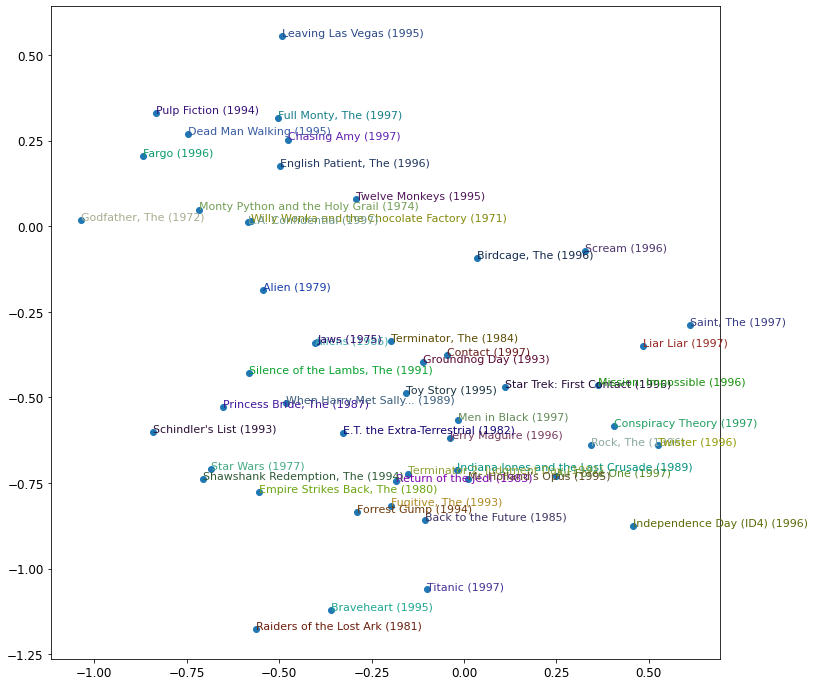

In [54]:
plt.figure(figsize=(12,12))
plt.scatter(X,Y)

for i,x,y in zip(top_movies[indices],X,Y):
    plt.text(x,y,i,color=np.random.rand(3)*0.7,fontsize=11)
plt.show()

Using fastai module to do collaborative filtering

In [55]:
learn = collab_learner(dls,n_factors=50,y_range=(0,5.5))

In [56]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.930618,0.946366,00:11
1,0.810814,0.863464,00:10
2,0.610484,0.856414,00:10
3,0.417473,0.877117,00:10
4,0.290359,0.884088,00:11


In [57]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [58]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]


['Rear Window (1954)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)']

We can use Embedding distance to find similarity learned between two movies

In [60]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors,movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Wife, The (1995)'

Bootstrapping a collaborative Filtering model:
When you have no training data to train a model, how do we recommend products to users


It is hard to find out if the latent factors are learned properly. if there is a bias, there is a difficulty in calling it out. Users who tend to like only one genre of movie, tend to be enthusiastic and pull the bias towards them, changing the weights of the latent factors thereby distorting the models. 
It requires that there is careful human monitoring so that the latent factors are learned to generalize over all the genres, cater to audiences of all tastes etc.

In [61]:
movie_factors.shape, user_factors.shape


(torch.Size([1665, 50]), torch.Size([944, 5]))

In [62]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [65]:
class CollabNN(Module):
    def __init__(self,user_sz, item_sz,y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+item_sz[1],n_act), 
        nn.ReLU(),
        nn.Linear(n_act,1))
        self.y_range=y_range
        
    def forward(self,x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs,dim=1))
        return sigmoid_range(x,*self.y_range)
        

In [66]:
model = CollabNN(*embs)


In [67]:
learn = Learner(dls, model,loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.01)

epoch,train_loss,valid_loss,time
0,0.946062,0.958087,00:17
1,0.916160,0.899499,00:13
2,0.852466,0.885833,00:13
3,0.816842,0.879417,00:13
4,0.774467,0.882167,00:12


fastai also has the provision to create models with additional hidden layers

In [69]:
learn = collab_learner(dls, use_nn=True, y_range=(0,5.5), layers=[100,50])
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,1.006856,0.994479,00:14
1,0.880056,0.930955,00:15
2,0.893111,0.905412,00:13
3,0.829206,0.878157,00:16
4,0.809854,0.876444,00:14


The EmbeddingNN class which inherits from TabularData class inspite of performing not so well compared to DotProductBias, has the capability to encode additional details like year of release etc.
It gets important to study Tabular Data first.